In [1]:
import numpy as np
import os
import random
from math import comb
from matplotlib import pyplot as plt

from ase.data import atomic_numbers, atomic_masses
from ase.io.lammpsdata import write_lammps_data
from ase.visualize import view
from ase.geometry import get_distances
from ase.io import read, write
from ase import Atoms
from ase.db import connect


from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics, StructOptimizer, CHGNetCalculator
from pymatgen.core import Structure
import warnings
import os

from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

mpr = MPRester("X95IHGgtNwjR1xILRRk9NImcElr5JlTH")

In [2]:
numOfX = 9
initialTemp = "100.0"
alloySystem = "LiKCl-chgnet-0.3.0-cell-relaxed"
potentialPath = "/ocean/projects/cts180021p/wuziqi/clease/mint-PD/PhaseDiagram-Clease/Liquid/GAP_potential/gap_LiKCl.xml"
chgnetDriverPath = "/nfs/turbo/coe-venkvis/ziqiw-turbo/LAMMPSs/lammps-ASC/potentials/CHGNET"
model_name = "0.3.0"
# model_name = "/ocean/projects/cts180021p/wuziqi/clease/mace/mace/calculators/foundations_models/2023-12-03-mace-mp.model-lammps.pt"
# model_name = "path /nfs/turbo/coe-venkvis/ziqiw-turbo/epoch999_e52_f152_s406_mNA.pth.tar"
# model_name = "/ocean/projects/cts180021p/wuziqi/clease/mint-PD/PhaseDiagram-Clease/Liquid/GAP_potential/gap_LiKCl.xml \"Potential xml_label=GAP_2021_9_27_0_1_17_37_618\""
multipicity = (2,2,2)

pair_style  = f"chgnet/gpu {chgnetDriverPath}"
# pair_style  = f"quip"
# pair_style  = f"mace no_domain_decomposition"
pair_coeff  =  f"* * {model_name}"

end0StructureMPid = 'mp-22905' # a = 2.55 2.46
end0StructureA = 2.55
# end1StructureMPid = 'mp-22983'
end1StructureMPid = 'mp-23193' # a = 3.18 
end1StructureA = 3.18


structure = mpr.get_structure_by_material_id(end0StructureMPid)
sg_analyzer = SpacegroupAnalyzer(structure)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms0 = AseAtomsAdaptor.get_atoms(primitive_structure)
cell0 = ase_atoms0.cell
ase_atoms0.set_cell(cell0.cellpar()[:3]*2*end0StructureA/cell0.cellpar()[0], scale_atoms=True)
view(ase_atoms0)

structure = mpr.get_structure_by_material_id(end1StructureMPid)
sg_analyzer = SpacegroupAnalyzer(structure)
primitive_structure = sg_analyzer.get_conventional_standard_structure()
ase_atoms1 = AseAtomsAdaptor.get_atoms(primitive_structure)
cell1 = ase_atoms1.cell
ase_atoms1.set_cell(cell1.cellpar()[:3]*2*end1StructureA/cell1.cellpar()[0], scale_atoms=True)
view(ase_atoms1)

xs = np.linspace(0, 1, numOfX, endpoint=True)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [38]:
print(np.arange(len(ase_atoms0.numbers))[ase_atoms0.numbers == 3])

[0 1 2 3]


In [3]:
startingList = []

In [4]:
ase_atoms0_tmp = ase_atoms0*(2,2,2)
ase_atoms0_tmp.numbers[np.array([8,9,10,11,16,17,18,19,32,33,34,35,56,57,58,59])] = 19
starting1 = ase_atoms0_tmp.copy()
startingList.append(starting1)
view(starting1)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

In [5]:
ase_atoms0_tmp = ase_atoms0.copy()
ase_atoms0_tmp.numbers[np.array([2,3])] = 19
ase_atoms0_tmp = ase_atoms0_tmp*(2,2,2)
starting2 = ase_atoms0_tmp.copy()
startingList.append(starting2)
view(starting2)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

In [6]:
ase_atoms0_tmp = ase_atoms0.copy()
ase_atoms0_tmp.numbers[np.array([2])] = 19
ase_atoms0_tmp = ase_atoms0_tmp*(2,2,2)
starting3 = ase_atoms0_tmp.copy()
startingList.append(starting3)
view(starting3)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

In [7]:
ase_atoms0_tmp = ase_atoms0.copy()
ase_atoms0_tmp.numbers[np.array([0,1,2])] = 19
ase_atoms0_tmp = ase_atoms0_tmp*(2,2,2)
starting4 = ase_atoms0_tmp.copy()
startingList.append(starting4)
view(starting4)

<Popen: returncode: None args: ['/Users/Michael_wang/opt/anaconda3/envs/casm...>

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


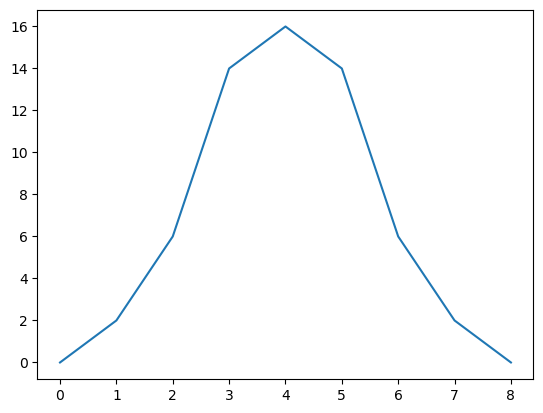

In [9]:
plt.plot(np.array([int(y) for y in np.array([comb(8,x) for x in np.linspace(0,8,9,endpoint=True, dtype=int)])/8])*2)

In [8]:
numberOfStrctrPerX = np.array([int(y) for y in np.array([comb(8,x) for x in np.linspace(0,8,9,endpoint=True, dtype=int)])/8])*2
np.sum(numberOfStrctrPerX)

60

In [9]:
def swap_z(starting, numberOfSwap):
    numberOfSwap = np.min((numberOfSwap, np.sum(starting.numbers == 3), np.sum(starting.numbers == 19)))
    candi19 = np.random.choice(np.arange(len(starting.numbers))[starting.numbers == 3], replace=False, size=numberOfSwap)
    candi3 = np.random.choice(np.arange(len(starting.numbers))[starting.numbers == 19], replace=False, size=numberOfSwap)
    starting.numbers[candi19] = 19
    starting.numbers[candi3] = 3

def change_x(starting, x, minChanges = 1):
    tmp = starting.copy()
    N = np.sum(tmp.numbers != 17)
    diffN = np.sum(tmp.numbers == 3) - int(N*x)
    
    # having too much Li
    if diffN > 0:
        candi = np.random.choice(np.arange(len(starting.numbers))[tmp.numbers == 3], replace=False, size=abs(diffN))
        tmp.numbers[candi] = 19
    # not enough Li
    elif diffN < 0:
        candi = np.random.choice(np.arange(len(starting.numbers))[tmp.numbers == 19], replace=False, size=abs(diffN))
        tmp.numbers[candi] = 3
    
    if minChanges - diffN > 0:
        swap_z(tmp, minChanges - diffN)
        
    return tmp

In [96]:
mediumList = []
for starting in startingList:
    for idx, x in enumerate(xs):
        tmpStarting = starting.copy()
        for jdx, i in enumerate(range(numberOfStrctrPerX[idx])):
            starting = change_x(starting, x)
            mediumList.append(starting)
        starting = tmpStarting.copy()

In [97]:
# with connect("mediumList.db") as db:
#     for atoms in mediumList:
#         db.write(atoms)

In [98]:
def validity_check(startingTmp):
    for i in range(len(startingTmp)-1):
        dis = startingTmp.get_distances(i, indices=range(i+1, len(startingTmp)), mic=True)
        if np.any(dis < 1):
            return False
    # for i in range(len(startingTmp.positions)-1):
    #     for j in range(i+1, len(startingTmp.positions)):
    #         dis = np.linalg.norm(startingTmp.positions[i] - startingTmp.positions[j])
    #         if dis < 1:
    #             return False
    return True

In [99]:
def perturb(starting):
    startingTmp = starting.copy()
    
    # perturb volume
    vScale = np.random.uniform(low=0.5, high=1.5, size=3)
    startingTmp.set_cell(startingTmp.cell*vScale, scale_atoms=True)
    
    # perturb positions
    low = -0.75
    high = 0.75
    count = 0
    while True:
        tmptmpPos = startingTmp.positions.copy()
        if count > 5000:
            low = -0.5
            high = 0.5
        startingTmp.positions[:,0] += np.random.uniform(low=low*vScale[0], high=high*vScale[0], size=len(startingTmp))
        startingTmp.positions[:,1] += np.random.uniform(low=low*vScale[1], high=high*vScale[1], size=len(startingTmp))
        startingTmp.positions[:,2] += np.random.uniform(low=low*vScale[2], high=high*vScale[2], size=len(startingTmp))
        
        # validity check
        if validity_check(startingTmp) or count > 10000:
            print(count)
            assert count != 10001
            break
        
        startingTmp.positions = tmptmpPos.copy()
        count += 1
        
    return startingTmp

In [100]:
# mediumList = startingList.copy()

repeat = 3

laterList = np.empty((repeat*len(mediumList)), dtype=object)
for i in range(repeat):
    # tmpMediumList = np.empty((len(mediumList)), dtype=object)
    for idx, starting in enumerate(mediumList):
        # tmpMediumList[idx] = perturb(starting)
        laterList[i*len(mediumList)+idx] = perturb(starting)
    # mediumList = tmpMediumList.copy()

2
1
1
4625
2
1
0
0
0
0
6
0
2
0
0
0
78
0
0
0
15
5
5001
0
0
17
0
0
0
14
0
90
7
0
0
38
20
0
0
3
25
0
5
11
3
21
0
1
4
1
0
0
0
0
0
0
0
2
0
5477
0
0
0
1
0
0
1
3
0
0
0
0
0
0
5
0
0
0
0
0
0
3
0
0
0
0
0
0
3
2
32
0
5
5
1
0
0
0
0
0
0
44
2
0
0
0
5
0
241
642
3
14
3
2
5
0
0
7
1
0
0
12
0
0
0
0
0
0
0
1
1
0
0
12
0
0
0
0
0
2
2
4
48
458
653
16
0
0
0
0
0
0
2
0
0
2
2
0
16
0
0
0
0
1
0
4
0
0
4
3
0
0
0
656
0
1
0
181
0
0
0
0
6
0
16
17
13
0
4
8
5
1
0
0
2
14
0
3
0
1
0
0
7
0
0
0
0
5001
22
0
0
0
0
5010
0
0
0
0
0
2
0
10
2
1
16
1
0
207
0
3
0
1
16
0
0
0
0
0
4
117
0
304
0
0
0
0
5
0
0
9
0
0
0
6
4
10
0
0
0
0
0
4
0
14
1
0
25
0
0
2
0
0
0
0
5
1
0
0
0
0
0
0
0
0
4
0
0
1
0
0
0
0
1
6
28
0
82
0
0
0
0
0
63
0
0
0
0
1
0
40
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
1
2
0
0
6
1
19
0
0
1
0
39
0
7
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
3
107
0
34
0
0
0
1
1
0
1
0
0
8
0
1
0
0
0
0
0
5
0
0
0
0
0
0
0
0
3417
0
0
1
0
0
1
0
0
0
0
5
0
0
0
2
0
9
0
0
0
25
1
0
0
0
10
0
0
0
11
0
0
0
0
0
0
1
2
0
0
3
0
0
0
0
0
0
0
0
9
0
0
48
0
5
8
33
0
0
0
1
0
0
0
0
0
70
0
0
1
5
1
